Genel Amaç: Kelime Tahmin Eden Bir Kahin İnşa Etmek

Bu kodun yaptığı şey, temelde bir "kahin" yetiştirmek. Bu kahin, ona birkaç harf verdiğimizde bir sonraki harfin ne olacağını tahmin etmeye çalışacak. Örneğin, "merha" dediğimizde "b" harfini tahmin etmesini umuyoruz. Bunu yapabilmesi için tonlarca yazı okuyarak (eğitim verisi) harflerin nasıl bir araya geldiğini öğrenmesi gerekiyor.

In [ ]:
# İlgili kütüphaneleri dahil edelim
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
words = open('/content/names.txt','r').read().splitlines()

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s : i + 1 for i , s in enumerate(chars)}
stoi['.'] = 0
itos = { i : s for s , i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
# bağlam uzunluğu: bir sonrakini tahmin etmek için kaç karaktere ihtiyacımız var?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append -- kırpma ve ekleme

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## 1. class Linear: (Doğrusal Katman - Beynin Nöron Bağlantıları)

In [ ]:
class Linear:

  def __init__(self, fan_in,fan_out , bias = True):
    # fan_in : gelen bağlantı sayısı (giriş nöron sayısı)
    # fan_out : giden bağlantı sayısı (çıkış nöron sayısı)
    # bias : Ekstra ayar düğmesi(eğilim)

    self.weight = torch.randn((fan_in,fan_out) , generator=g) / fan_in**0.5
    # Ağırlıklar : her bir girişin çıkışı ne kadar etkileyeceğini belirten katsayılar
    # Rastgele başlatılır ama çok büyük ve çok küçük olmasın diye fan_in**0.5 e bölünerek ayar yapılır.Eğitim sırasında hokey sopası grafiği oluşmaz.İlk loss ikinci loss a yakındır
    self.bias = torch.zeros(fan_out) if bias else None
    # Eğer istenirse her çıkışa eklenecek sabit değer.Başlanğıçta sıfır

  def __call__(self,x):
    # Katmanın esas işi yaptığı yer bu kısım

    self.out = x @ self.weight # Girdiyi ağırlıklarla çarp. @ : Matris çarpımı
    if self.bias is not None:
      self.out += self.bias   #Eğer bias varsa onuda sonuca ekle
    return self.out


  def parameters(self):
    # Bu katmanın öğrenilecek parçaları-parametreleri -
    return [self.weight] + ([] if self.bias is None else [self.bias])


Hikayesi : Doğrusal katmanı beynimizdeki bir grup nöron gibi düşünebiliriz.
- fan_in : Bu nöron grubuna kaç farklı yerden sinyal(bilgi) geliyor?
- fan_out : Bu nöron grubu kaç farklı yere sinyal gönderiyor?
- self.weight : Her bir gelen sinyalin giden sinyalleri ne kadar kuvvetli etkileyeceğini belirleyen'bağlantı güçleri'.
Kahinimiz ilk başta bu bağlantı güçlerini rastgele atıyor,ama zamanla hangi bağlantıların önemli olduğunu öğrenecek.
- fan_in**0.5 ile bölme ise başlangıçta sinyallerin çok fazla veya çok az güçlenip kaybolmasını engellemek için dengeleme.Sanki yeni bir müzik aletinin tellerini ilk kez akort etmek gibi, çok gevşek yada çok gergin olmamalı.
- self.bias : Her bir giden sinyale eklenen sabit bir 'önyargı' veya 'eğilim'.Bazen hiçbir giriş olmasa bile nöronun biraz aktif olmasını sağlar.Sanki bazı nöronlar doğuştan biraz heyecanlı veya sakin.

- __call__(self,x) : Bu fonksiyon katmana bilgi(x) geldiğinde ne olacağını tanımlar.Gelen bilgi , bağlantı güçleri(self.weight) ile çarpılır.Eğer bir önyargı(self.bias) varsa oda eklenir.Sonuç bu katmanın çıktısıdır.
- parameters : Kahinin eğitim sırasında ayarlayacağı'düğmeler'bunlardır : Bağlantı güçleri(self.weight) ve önyargılar(self.bias)

## 2.  class BatchNorm1d: (Batch Normalization - Sınıfı hizaya getiren öğretmen)

In [ ]:
class BatchNorm1d:

  def __init__(self, dim , eps = 1e-5 , momentum = 0.1):
    #dim : Normalleştirilecek özellik sayısı --> nöron sayısı -- n_hidden
    # eps : Sıfıra bölmeyi engellemek için çok küçük bir sayı
    # momentum : koşan ortalamayı ve varyansı güncellerken ne kadar yeni bilgiye ağırlık verileceği

    self.eps = eps
    self.momentum = momentum
    self.training = True  # Varsayılan olarak eğitim modunda
    # Öğrencilecek parametreler
    self.gamma = torch.ones(dim)   #Ölçekleme faktörü
    self.beta = torch.zeros(dim)   # Kaydırma faktörü
    #Koşan istatistikler ---(eğitimde öğrenir , testte kullanılır ortalama ve varyasyon)
    self.running_mean = torch.zeros(dim)  # Koşan ortalama
    self.running_var = torch.ones(dim)  # Koşan varyans


  def __call__(self , x):

    if self.training:
      xmean = x.mean(0,keepdim=True)  # Mevcut mini-batch in ortalaması
      xvar = x.var(0,keepdim =  True)  # Mevcut mini_batch e ait varyans

    else :  # Test modunda
      xmean = self.running_mean   #Daha önce öğrenilmiş koşan ortalamayı kullan
      xvar = self.running_var     # Daha önce öğrenilmiş koşan varyansı kullan

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Veriyi normalize edelim ortalama 0 varyans 1
    self.out = self.gamma * xhat + self.beta # Normalize edilmiş veriyi ölçekle(gamma) ve kaydır (beta)

    if self.training : #Eğitim modundaysak koşan istatistikleri güncelle
      with torch.no_grad(): # Bu ayarlama için gradyan hesaplaması yapma
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    # Bu katmanın öğrenilecek parametreleri : gamma ve beta
    return [self.gamma , self.beta]

Hikayesi : BatchNorm katmanını , bir sınıftaki öğrencilerin notlarını düzenleyen bir öğrenci gibi düşünebiliriz.
- Farklı derslerden(önceki katmanlardan) gelen notlar(sinyaller) çok farklı ölçeklerde olabilir.Biri 0-100 arası diğeri 0-10 arası gibi.Bu durum kahinin öğrenmesini zorlaştırır.
- self.training : Öğretmen sınav sırasında mı(True) yoksa dönem sonu değerlendirmesi(False) için mi notlara bakıyor?

- xmean , xvar : Sınav sırasında öğretmen , o anki sınıfın(mini-batch) "ortalamasına" ve notların ne kadar dağıldığını "varyans" hesaplar.

- running_mean , running_var : Dönem boyunca öğretmen tüm sınavların genel bir ortalamasını ve dağılımını aklında tutar."momentum" ile yeni sınavların bu genel ortalamayı ne kadar etkileyeceğini ayarlar.Eski bilgilere çok takılıp kalmaz ama her yeni sınavla da fikrini tamamen değiştirmez.

- xhat : Öğretmen , her öğrencinin notunu sınıf ortalamasından çıkarır ve dağılıma böler.Böylece notlar standartlaşır.(sanki herkes aynı zorlukta bir sınavdan geçmiş gibi). "eps" kimsenin notu sıfıra bölünmesin diye eklenen minik bir güvencedir.
- self.gamma , self.beta : Standartlaştırma sonrası öğretmen , "Acaba bu sınıfın genel seviyesini biraz yukarı mı çeksem(beta) yada not aralığını biraz genişletsem mi(gamma)? diye düşünür.Bu gamma ve beta değerlerini de kahinimiz zamanla öğrenir.Belkide bazı derslerin(katmanların) notlarının biraz daha "yayvan" ve ya biraz daha 'toplu'olması daha iyidir.

- Neden Gerekli ? : Bu hizaya getirme işlemi kahinin daha hızlı ve daha stabil öğrenmesine yardımcı olur.Sinyallerin katmanlar arasından akarken çok büyümesini veya çok küçülmesini engeller.

## 3.class Tanh: (Hiperbolik Tanjant - Duygu Kontrol Mekanizması)

In [ ]:
class Tanh:

  def __call__(self , x):
    self.out = torch.tanh(x) # Girdiyi hiperbolik tanjant fonksiyonundan geçir
    return self.out

  def parameters(self):
    return [] #Bu katmanın öğrenilecek bir paramtresi yok

Hikayesi: Tanh katmanını, bir insanın duygularını kontrol eden bir mekanizma gibi düşünün.
- Bazen sinyaller çok coşkulu (çok büyük pozitif) veya çok karamsar (çok büyük negatif) olabilir.
- torch.tanh(x): Bu fonksiyon, gelen sinyalleri alır ve onları -1 ile +1 arasında bir değere sıkıştırır. Çok pozitifse +1'e yakınsar, çok negatifse -1'e yakınsar, ortadaysa ona göre bir değer alır.
- Neden Gerekli? Bu, sinir ağındaki sinyallerin kontrolden çıkmasını engeller. Kahinin aşırı tepkiler vermesini önler, onu daha "dengeli" yapar. Öğrenilecek bir parametresi yoktur, sadece sabit bir matematiksel işlem yapar.

## 4. Değişkenler ve Ağın Kurulumu

In [ ]:
n_embd = 10 # Karakter gömme vektörlerinin boyutu(Her harfi 10 sayı ile temsil et)
n_hidden = 100 # Gizli katmandaki nöron sayısı (beyindeki ara işlem birimleri)
g = torch.Generator().manual_seed(42) # Tekrarlanabilirlik için rastgele sayı üreteci
# vocab_size : Alfabedeki toplam harf sayısı + '.'
# block_size = Bir sonraki harfi tahmin etmesi için makineye kaç harflik gruplar verileceğini gösterir

C = torch.randn((vocab_size , n_embd) , generator= g)
# C : Karakter gömme matrisi. Her bir harf için rastgele başlatılmış bir 'anlam' vektörü -- > Her harfin n_embd kadar anlamı var Örn : Büyük başlamış mı , hangi harften sonra geldiği gibi...
# vocab_size satır : Her harf için bir satır , n_embd sütun her harfin 10 sayılık temsili

layers = [
    Linear(n_embd * block_size , n_hidden , bias = False), BatchNorm1d(n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden , bias = False) , BatchNorm1d(n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden , bias = False) , BatchNorm1d(n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden , bias = False) , BatchNorm1d(n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden , bias = False) , BatchNorm1d(n_hidden) , Tanh(),
    Linear(n_hidden , vocab_size , bias = False) , BatchNorm1d(vocab_size),
]

# layers : Beyni oluşturan katmanlar
# Birinci katman : Gömülmüş karakter vektörlerini alır (n_embd * block_size),n_hidden nörona dönüştürülür.
# Ara katmanlar : n_hidden nörondan n_hidden nörona bilgi işler
# Son katman : n_hidden nörondan alfabedeki her harf için bir olasılık skoruna (vocab_size) dönştürür.
# Dikkat : Son katmanda Tanh yok! çünkü olasılık skorları -1 ve 1 arasında olmak zorunda değil.
# bias = False : Bu modelde biaslar (ön yargılar kullanılmadı).Bunun yerine BatchNormun betası benzer bir işlevi görür


- n_embd = 10: Her bir harfi temsil etmek için 10 sayı kullanacağız. "a" harfi [0.1, -0.5, ..., 0.8] gibi 10 sayılık bir vektör olacak. Bu, harflerin "anlamını" veya "kimliğini" sayısallaştırmanın bir yolu.
- n_hidden = 100: Kahinimizin beynindeki gizli katmanlarda 100'er tane "düşünce hücresi" (nöron) olacak. Bu hücreler, gelen bilgiyi işleyip daha karmaşık desenler öğrenmeye çalışacak.
- g: Bu, rastgele sayıları her zaman aynı sırada üretmek için bir "tohum". Böylece deneyi her tekrarladığımızda aynı başlangıç koşullarına sahip oluruz, sonuçları karşılaştırmak kolaylaşır.
- C: Bu bizim "harf sözlüğümüz". vocab_size (alfabedeki harf sayısı) kadar satırı ve n_embd (10) kadar sütunu var. Her satır, bir harfin 10 sayılık temsilini (gömme vektörünü) içerir. Başlangıçta bu temsiller rastgele, ama kahinimiz eğitim sırasında hangi harflerin birbirine benzediğini (vektörlerinin de benzemesi gerektiğini) öğrenecek.
- layers: Bu, kahinimizin "düşünce hattı".
Giriş İşleme: Önce Linear katman, verilen block_size (mesela 3 harf) kadar harfin gömme vektörlerini (n_embd * block_size boyutunda birleşik bir vektör) alır ve bunu n_hidden (100) boyuta indirger/dönüştürür.
- Normalleştirme ve Sıkıştırma: Sonra BatchNorm1d bu 100 sinyali hizaya sokar, Tanh da -1 ile +1 arasına sıkıştırır.
- Derin Düşünme: Bu "Linear -> BatchNorm1d -> Tanh" bloğu birkaç kez tekrarlanır. Her tekrar, bilginin daha da işlenmesi, daha soyut özelliklerin çıkarılması anlamına gelir. Sanki bir problem üzerinde katman katman düşünmek gibi.
- Sonuç Üretme: En son Linear katman, bu işlenmiş 100 sinyali alır ve vocab_size (alfabedeki harf sayısı) kadar skora dönüştürür. Her skor, bir sonraki harfin o harf olma olasılığıyla ilgilidir. Sonrasında bir BatchNorm1d daha var, bu da son çıktı skorlarını normalleştirmeye yardımcı oluyor. Burada Tanh yok, çünkü tahmin edilen skorların -1 ile 1 arasında olması gerekmiyor.

## 5. Başlangıç Ayarları (Kahinimize İlk İpuçları)


In [ ]:
with torch.no_grad(): # Bu blokta yapılan işlemler için gradyan hesaplama--şimdilik gerek yok
 # Son katman  : Daha az emin yap(olasılıkları yumuşat)
 layers[-1].gamma *= 0.1
 # layers[-1].weight *= 0.1 # Ağırlıklarıda küçültebilirdik ama burada sadece gamma ayarladık
 # Diğer tğm katmanlara kazanç uygula --- > Sinyallerin sönümlenmesini engelle
 for layer in layers[:-1]:
  if isinstance(layer,Linear):
    layer.weight *= 1.0 # Normalde Tanh için 5/3 gibi bir kazanç kullanılır.(Kaiming)---Değiştirilebilir

- torch.no_grad() : Bu kısımda sadece ayar yapıyoruz öğrenme değil, o yüzden hesaplamaların geçmişini tutmaya gerek yok.
- layers[-1].gamma *= 0.1 : Son katmanın (tahminleri üreten katman) "gamma" sını küçültüyoruz.Bu BatchNorm'un ölçekleme faktörünü azaltır.Sonuç olarak kahinimiz başlangıçta tahminlerinde daha 'mütevazi' olur. Her harfe neredeyse eşit olasılık verir.Bu eğitimin başında çok keskin ve yanlış tahminler yapmasını engeller ve daha yumuşak bir başlangıç yapmasını sağlar.Sanki kahine 'Hemen herşeyi bildiğini sanma , yavaş yavaş öğren' demek gibi

- layer.weight *= 1.0 #5/3: Diğer doğrusal katmanların ağırlıklarını bir "kazanç" (gain) faktörüyle çarpıyoruz. Tanh aktivasyon fonksiyonu kullanıldığında, sinyallerin katmanlardan geçerken ne çok küçülüp kaybolmaması ne de çok büyüyüp patlamaması için genellikle 5/3 gibi bir kazanç önerilir (Kaiming initialization). Buradaki kodda 1.0 kullanılmış (belki daha önce 5/3 idi veya farklı bir strateji izleyebilirdik--Değişebilir). Bu, bilginin ağ içinde sağlıklı bir şekilde akmasına yardımcı olur.

## 6. Parametrelerin Toplanması ve Eğitime Hazırlık



In [ ]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
# parameters : Öğrenilecek tüm parçalar : Harf sözlüğü(C) ve tüm katmanların ağırlıkları beta ve gammaları
print(sum(p.nelement() for p in parameters)) # Toplam kaç tane ayarlanabilir düğme -parametre- var?
for p in parameters:
  p.requires_grad = True # Tüm parametreler için "gradyan hesapla" bayrağını açtık

47024


- parameters: Kahinimizin beynindeki tüm "ayarlanabilir düğmeleri" (harf sözlüğü C, her Linear katmanın ağırlıkları, her BatchNorm1d katmanın gamma ve beta'ları) tek bir büyük listeye topluyoruz.
- sum(p.nelement() ...): Bu, kahinimizin toplam kaç tane öğrenilebilir "düğmesi" olduğunu sayar. Modelin karmaşıklığını gösterir.
- p.requires_grad = True: PyTorch'a (veya bu özel implementasyona) diyoruz ki: "Bu listedeki her bir parametrenin, yapacağımız tahminlerdeki hataya ne kadar katkısı olduğunu takip et." Bu, "gradyan hesaplama" denilen şeyin temelidir ve öğrenme için kritik öneme sahiptir.

## 7. Eğitim Döngüsü (Kahinimizin Okul Yılları)


In [ ]:
max_steps = 200000 # Toplam eğitim adımı
batch_size = 32   # Her seferinde kaç örnekle çalışılacak(mini-batch)
lossi = []        # Her adımda hata miktarını kaydetmek için
ud = []           # Parametre güncellemelerinin büyüklüğünü kaydetmek için

for i in range(max_steps): # Belirlenen adım sayısı kadar tekrarla

  # 1. mini-batch oluşturma --rastgele bir grup öğrenci seçmek gibi

  ix = torch.randint(0 , Xtr.shape[0] , (batch_size,) , generator = g)  # Eğitim verisinden rastgele batch_size kadar örnek seç
  Xb , Yb = Xtr[ix] , Ytr[ix]  #Seçilen örneklerin girişleri

  # 2. İleri yayılım (Forward Pass - Kahinin tahmini)
  emb = C[Xb]  # Giriş harflerini(indexlerini) sözlükten(C) vektörlere dönüştür --- Bu kod için Her bir harf için 10 özellik(boyut)--
  x = emb.view(emb.shape[0] , -1)  #Vektörleri birleştir (Eğer block_size > 1 ise)  --- Bu kod için 3 harf 10 boyut 3*10 = 30 giriş
  for layer in layers:
    x = layer(x) # Veriyi katmanlardan sırayla geçir
    # x : Şimdi kahinimizin her bir olası sonraki harf için verdiği skorları içeriyor

  loss = F.cross_entropy(x , Yb)  # Hata hesaplama (Kahinin tahmini ne kadar kötüydü?)
  # F.cross_entropy : Skorları olasılıklara dönüştürür ve doğru harfin olasılığını maximize etmeye çalışır

  # 3. Geri yayılım ( Backward Pass - Kahinin hatalarından ders çıkarması)
  for layer in layers:
    layer.out.retain_grad()   # Opsiyonel---Hata ayıklama için : Her katmanın çıktısının gradyanını sakla -- Grafikte görmek için tutuyoruz normalde gereksiz

  for p in parameters:
    p.grad = None    # Önceki adımlardan kalan eski gradyanları temizle !!! Bu önemli yığılma olmaması için -- Yanlış gradyan hesabı ...
  loss.backward()    # **SİHİR** Hatanın her bir parametreye nasıl yayıldığını hesapla (gradyanlar - türevleri---zincir kuralı ** çıktının bir öncekine göre türevi ...)


  # 4. Güncelleme --Update (Kahinin kendini Geliştirmesi)
  lr = 0.1 if i < 150000 else 0.01    # Öğrenme oranı --- Başta hızlı 150000 adıma kadar sonrasında öğrenme yavaşlasın
  for p in parameters:
    p.data += -lr * p.grad   # Parametreleri hatayı azaltacak yönde (gradyanın tersi) küçük bir adımla güncelle


  # 5. İstatistikleri Takip

  if i % 10000 == 0 : # Her 10000 adımda bir
    print(f'{i:7d}/{max_steps : 7d}:{loss.item() : .4f}')  #Mevcut hata miktarını yazdır
  lossi.append(loss.log10().item())  # Hatanın logaritmasını kaydet  --- GRAFİK İÇİN

  with torch.no_grad() : # Gradyan hesaplaması yapmadan
    ud.append( [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters])
    # Her parametre için (Öğrenme oranı * gradyanın standart sapması) / (parametrenin standart sapması)
    #Bu oran : Güncellemenin parametrenin kendisine kıyasla ne kadar büyüdüğünü gösterir.
    # Çok büyükse eğitim istikrarsız , çok küçükse yavaş olabilir

  #if i >= 1000 : # Hata ayıklama kısmı --- > İlk 1000 adımdan sonra DUR ---> !!! Tam eğitim sırasında kaldırılır
    #break

      0/ 200000: 2.1638
  10000/ 200000: 2.2331
  20000/ 200000: 2.2097
  30000/ 200000: 2.1270
  40000/ 200000: 1.9724
  50000/ 200000: 1.7915
  60000/ 200000: 2.3723
  70000/ 200000: 2.0600
  80000/ 200000: 2.1408
  90000/ 200000: 2.0189
 100000/ 200000: 1.9004
 110000/ 200000: 2.4658
 120000/ 200000: 1.8988
 130000/ 200000: 1.9870
 140000/ 200000: 2.1896
 150000/ 200000: 2.1087
 160000/ 200000: 1.9042
 170000/ 200000: 2.3861
 180000/ 200000: 2.3712
 190000/ 200000: 2.2597


- max_steps: Kahinimiz toplam 200,000 "ders" alacak. Her ders bir adımdır.
- batch_size = 32: Her derste, kahinimiz rastgele seçilmiş 32 örnek üzerinden çalışacak. Tüm eğitim verisini bir anda işlemek çok maliyetli olurdu. Bu, sanki bir öğretmen her ders farklı 32 öğrenciye odaklanıyor gibi.
- Döngü (for i in range(max_steps)):
  > 1-Mini-batch (Xb, Yb): Eğitim verisinden (Xtr, Ytr - bunlar gerçek harf dizileri ve bir sonraki doğru harfler) rastgele 32 tane örnek seçilir. Xb kahine verilecek girdi harf dizileri, Yb ise bu dizilerden sonra gelmesi gereken doğru harfler.

  > 2-İleri Yayılım:
    - emb = C[Xb]: Girdi harfleri (aslında harflerin numaraları/indeksleri) C sözlüğünden bakılarak 10'ar sayılık vektörlere dönüştürülür.
    - x = emb.view(...): Eğer kahine birden fazla harf veriyorsak (örn. 3 harf), bu 3 harfin 10'ar sayılık vektörleri birleştirilerek tek bir uzun vektör (30 sayı) haline getirilir.
    - for layer in layers: x = layer(x): Bu birleşik vektör, daha önce tanımladığımız katmanlardan (Linear, BatchNorm, Tanh...) sırayla geçer. Her katman bilgiyi işler ve bir sonrakine aktarır.
    - Sonuç x: Artık x, kahinimizin her bir olası sonraki harf için verdiği "skorları" içerir. Yüksek skor, o harfin daha olası olduğu anlamına gelir.

  > 3- Kayıp (Hata) Hesaplanması (loss = F.cross_entropy(x, Yb)):
    - F.cross_entropy (PyTorch'un bir fonksiyonu varsayılıyor) kahinimizin tahmin skorları (x) ile gerçek doğru harfleri (Yb) karşılaştırır. Kahin doğru harfe ne kadar düşük bir skor verdiyse (veya yanlış harflere ne kadar yüksek skor verdiyse) loss (kayıp/hata) o kadar büyük olur. Amaç bu kaybı en aza indirmektir.

  > 4-Geri Yayılım (loss.backward()):
    - Bu, sihirli kısımdır. Hesaplanan loss değerinden başlayarak, ağdaki her bir parametrenin (ağırlıklar, biaslar, gammalar, betalar) bu hataya ne kadar katkıda bulunduğu hesaplanır. Bu katkıya "gradyan" denir. Gradyan, parametrenin hangi yönde ve ne kadar değiştirilirse hatanın azalacağını gösteren bir ok gibidir.
    - p.grad = None: Her adımdan önce eski gradyanlar sıfırlanır, çünkü her mini-batch için gradyanlar yeniden hesaplanır.
    - layer.out.retain_grad(): Bu genellikle hata ayıklama (debug) için kullanılır. Her katmanın çıktısının gradyanını da saklamamızı sağlar, normal bir eğitimde genellikle buna ihtiyaç duyulmaz.

    > 5-Güncelleme (p.data += -lr * p.grad):
    - lr (learning rate - öğrenme oranı): Kahinimizin ne kadar "hızlı" öğreneceğini belirler. Çok büyük olursa, doğru ayarı kaçırabilir; çok küçük olursa çok yavaş öğrenir. Burada bir strateji var: ilk 150,000 adımda lr = 0.1, sonra lr = 0.01'e düşürülüyor. Bu, "önce kaba ayar yap, sonra ince ayar" gibi bir yaklaşımdır.
    - Her bir parametre (p), hesaplanan gradyanının (p.grad) tersi yönünde, öğrenme oranı kadar küçük bir adımla güncellenir. Yani, eğer bir ağırlığı artırmak hatayı azaltıyorsa (gradyan negatifse), ağırlık artırılır. Eğer azaltmak hatayı azaltıyorsa (gradyan pozitifse), ağırlık azaltılır. Bu, sanki bir dağdan aşağı en kısa yolu bulmaya çalışmak gibidir; her adımda en dik yokuş aşağı yöne doğru ilerlersiniz.

    > 6-İstatistikler:
    - lossi.append(...): Her adımdaki kayıp değeri bir listeye eklenir. Daha sonra bu liste, kahinimizin zamanla ne kadar iyi öğrendiğini gösteren bir grafik çizmek için kullanılabilir.
    - ud.append(...): Bu "update ratio" (güncelleme oranı) metriği, parametre güncellemelerinin parametrelerin kendi büyüklüklerine kıyasla ne kadar olduğunu ölçer. İdealde bu oranın 1e-3 civarında olması beklenir. Çok yüksekse eğitim kararsız olabilir, çok düşükse eğitim çok yavaş ilerliyor olabilir.

- if i >= 1000: break: Bu satır, kodun tamamının çok uzun sürmemesi için, hata ayıklama amacıyla konulmuş. Normalde tam bir eğitim için bu satır kaldırılır ve max_steps (200,000) adım boyunca eğitim devam eder.

Özetle Kahinimizin Eğitim Macerası

1. Harfleri Tanıma: Kahin, harfleri özel sayısal kodlarla (C matrisi) temsil etmeyi öğrenir.
2. Düşünme Aşamaları: Gelen harf dizisini alır, birçok katmandan (layers) geçirerek işler. Her katman, bilgiyi biraz daha rafine eder, desenleri bulmaya çalışır. (Linear, BatchNorm1d, Tanh)
3. Tahmin Yapma: Sonunda, bir sonraki harfin ne olabileceğine dair bir dizi skor üretir.
4. Not Alma: Tahmini, gerçek doğru harfle karşılaştırılır ve bir "hata notu" (loss) alır.
5. Ders Çıkarma: Bu hata notunu kullanarak, beynindeki tüm bağlantı güçlerini ve ayar düğmelerini (parameters) minik minik günceller. Amacı, bir sonraki sefer daha iyi bir tahmin yapmaktır.
6. Tekrar, Tekrar, Tekrar: Bu işlem yüz binlerce kez tekrarlanır, ta ki kahinimiz harflerin sırrını çözüp usta bir tahminci olana kadar!

layer 2 (      Tanh): mean -0.05, std 0.72, saturated: 18.53%
layer 5 (      Tanh): mean -0.03, std 0.75, saturated: 20.19%
layer 8 (      Tanh): mean -0.01, std 0.78, saturated: 21.78%
layer 11 (      Tanh): mean +0.00, std 0.78, saturated: 23.34%
layer 14 (      Tanh): mean +0.02, std 0.79, saturated: 23.66%


Text(0.5, 1.0, 'activation distribution')

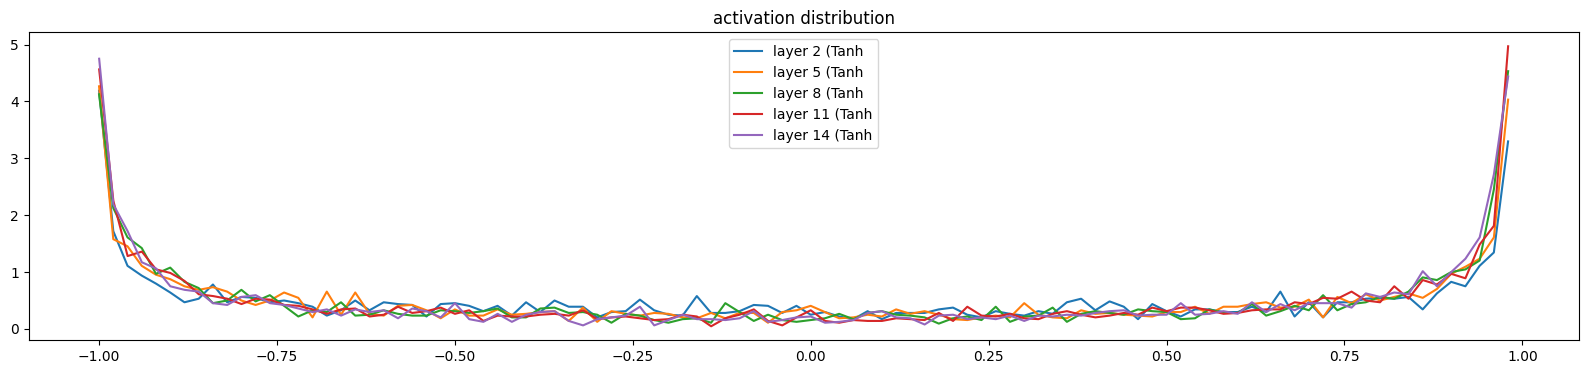

In [14]:
# Visualize histograms
plt.figure(figsize = (20,4))
legends = []

for i , layer in enumerate(layers[:-1]):
  if isinstance(layer , Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

- Şimdi, bu kahinin işçilerinin (nöronlarının) ne kadar heyecanlı olduğunu anlamak istiyoruz. Eğer çoğu işçi ya hep çok heyecanlı (1’e yakın) ya da hep çok sakin (-1’e yakın) ise, kahşn iyi öğrenemez. Çünkü işçiler, farklı durumlarda farklı şeyler söylemeli ki kahin çeşit çeşit şeyler öğrenebilsin. İşte bu grafik, işçilerin heyecan seviyelerini gösteriyor. Her renk, kahinin farklı bir “katmanındaki” (layer) işçileri temsil ediyor.

- Grafikte şunu görüyoruz:

  > Bazı katmanlarda işçiler genelde 0’a yakın, yani dengeli. Ama bazen -1 ve 1’e çok yakın oluyorlar, bu da “fazla heyecanlı” ya da “fazla sakin” demek.
“Saturated” denen bir şey var: Bu, işçilerin % kaçının çok heyecanlı veya çok sakin olduğunu söylüyor. Mesela, bir katmanda bu oran %2.78 ise, işçilerin %2.78’i ya çok sakin ya da çok heyecanlı.

- Bu grafik, kahinin işçilerinin sağlıklı çalışıp çalışmadığını anlamamıza yardım ediyor. Eğer işçiler çok dengesizse (hep -1 veya 1’de), kahinin öğrenmesini zorlaştırır. Biz istiyoruz ki işçiler genelde 0 civarında olsun, ama biraz da farklı farklı şeyler söylesin.



- Kodun Amacı
Bu kod, sinir ağının katmanlarındaki aktivasyonların (tanh çıktılarının) dağılımını görselleştiriyor. Özellikle, her Tanh katmanından sonra nöronların çıktıları analiz ediliyor. Aktivasyonların dağılımı, sinir ağının sağlıklı çalışıp çalışmadığını anlamak için önemli bir teşhis aracıdır.

- Çıktı (Grafik ve Metin)
Grafik, farklı katmanlardaki Tanh aktivasyonlarının histogramlarını gösteriyor. Metin kısmında ise her katman için şu istatistikler veriliyor:

  - Mean (Ortalama): Aktivasyonların ortalaması.
  - Std (Standart Sapma): Aktivasyonların ne kadar dağınık olduğu.
  - Saturated (Doyma Oranı): Aktivasyonların % kaçının mutlak değerinin 0.97’den büyük olduğu (yani -1 veya 1’e çok yakın olduğu).

- Grafik:

  - X ekseni: Tanh aktivasyon değerleri (-1 ile 1 arasında).
  - Y ekseni: Yoğunluk (density), yani bu değerlerin sıklığı.
  - Her renk, farklı bir katmanı temsil ediyor (layer 2, 5, 8, 11, 14).
  - Grafik, her katmandaki aktivasyonların nasıl dağıldığını gösteriyor.

  

- plt.figure(figsize=(20, 4)): Matplotlib ile bir grafik oluşturur. Grafiğin boyutu 20 birim genişlik, 4 birim yükseklik.
- legends: Grafikteki etiketleri (legend) saklamak için bir liste.
- layers[:-1]: Son katmanı (çıktı katmanı) hariç tüm katmanları döngüye alır, çünkü çıktı katmanı Tanh değil, bir BatchNorm1d.
- if isinstance(layer, Tanh): Yalnızca Tanh katmanlarını seçer. Kodda layers listesi şu şekilde:
  - [Linear, BatchNorm1d, Tanh, Linear, BatchNorm1d, Tanh, ..., Linear, BatchNorm1d]
  - Tanh katmanları, sırasıyla indeks 2, 5, 8, 11, 14’te.

- t = layer.out: Tanh katmanının çıktısı (tanh(x)), (batch_size, n_hidden) boyutunda (örneğin, (32, 100)).
- İstatistikler:
  - t.mean(): Aktivasyonların ortalaması. İdeal olarak 0’a yakın olmalı, çünkü tanh simetrik bir fonksiyon.
 - t.std(): Standart sapma. Bu, aktivasyonların ne kadar yayıldığını gösterir. İdeal olarak, 0.5-0.7 civarında olmalı (çok düşükse öğrenme yavaş, çok yüksekse kararsız olabilir).
 - (t.abs() > 0.97).float().mean()*100: “Doyma oranı” (saturated). Tanh çıktıları -1 veya 1’e yakınsa (mutlak değer > 0.97), bu nöronlar “doymuş” demektir ve gradyanları sıfıra yakındır (vanishing gradient). Bu oran düşük olmalı.
- Çıktı Örneği:
 - layer 2 (Tanh): mean -0.00, std 0.63, saturated: 2.78%:
 - Ortalama: -0.00 (0’a çok yakın, iyi).
 - Standart sapma: 0.63 (iyi bir yayılım).
 - Doyma oranı: %2.78 (biraz yüksek, ama kabul edilebilir).

- torch.histogram(t, density=True): Aktivasyonların histogramını hesaplar.
- hy: Yoğunluk değerleri (y ekseni).
- hx: Kutu sınırları (x ekseni).
- density=True: Toplam alan 1 olacak şekilde normalize eder.
- plt.plot(hx[:-1].detach(), hy.detach()): Histogramı çizgi grafiği olarak çizer. detach() ile tensörleri NumPy array’ine çevirir.
- legends.append(...): Her katman için bir etiket ekler.

- plt.legend(legends): Grafikte etiketleri gösterir (örneğin, “layer 2 (Tanh)”).
- plt.title('activation distribution'): Grafiğe başlık ekler.

- Çıktının Analizi
> Metin Analizi

- Ortalama (Mean): Tüm katmanlarda ortalama 0’a çok yakın (±0.00). Bu, iyi bir işaret, çünkü tanh simetrik bir fonksiyon ve BatchNorm aktivasyonları sıfır merkezli yapıyor.
- Standart Sapma (Std): 0.63-0.65 aralığında. Bu, aktivasyonların -1 ile 1 arasında iyi bir yayılım gösterdiğini, ancak uçlara çok yığılmadığını belirtir. İdeal bir değer, 0.5-0.7 civarıdır.
- Doyma Oranı (Saturated):

Layer 2: %2.78 (biraz yüksek).
Layer 5: %2.56.
Layer 8: %2.25.
Layer 11: %1.69.
Layer 14: %1.88.
- Genel olarak, katmanlar ilerledikçe doyma oranı azalıyor. Bu, BatchNorm’un aktivasyonları dengelediğini ve ağın derinleştikçe daha sağlıklı çalıştığını gösteriyor. Ancak, %2 civarı hala biraz yüksek; ideal olarak %1’in altında olmalı.



> Grafik Analizi

- Dağılım Şekli: Histogramlar, genelde 0 civarında yoğunlaşmış, ama -1 ve 1’e doğru hafif kuyruklar var.

0 civarında yoğunluk: Çoğu nöronun aktivasyonu 0’a yakın, bu da gradyanların sağlıklı olduğu anlamına gelir (tanh’ın türevi 0’da maksimumdur: <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mn>1</mn><mo>−</mo><msup><mtext>tanh</mtext><mn>2</mn></msup><mo stretchy="false">(</mo><mn>0</mn><mo stretchy="false">)</mo><mo>=</mo><mn>1</mn></mrow><annotation encoding="application/x-tex">1 - \text{tanh}^2(0) = 1</annotation></semantics></math>).
-1 ve 1’de kuyruklar: Bazı nöronlar doymuş (saturated), yani <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mtext>tanh</mtext><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>≈</mo><mo>±</mo><mn>1</mn></mrow><annotation encoding="application/x-tex">\text{tanh}(x) \approx \pm 1</annotation></semantics></math>. Bu nöronlar için gradyanlar sıfıra yakın: <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mn>1</mn><mo>−</mo><mo stretchy="false">(</mo><mo>±</mo><mn>1</mn><msup><mo stretchy="false">)</mo><mn>2</mn></msup><mo>≈</mo><mn>0</mn></mrow><annotation encoding="application/x-tex">1 - (\pm 1)^2 \approx 0</annotation></semantics></math>, bu da öğrenmeyi durdurabilir (ölü nöronlar).


- Katmanlar Arası Farklılık:

Erken katmanlar (örneğin, layer 2, kırmızı çizgi): -1 ve 1’de daha fazla yığılma var (%2.78 doyma oranı).
Daha derin katmanlar (örneğin, layer 11, mor çizgi): Yığılma azalıyor (%1.69), dağılım daha dengeli.
Bu, BatchNorm’un derin katmanlarda aktivasyonları daha iyi kontrol ettiğini gösteriyor.



- Neden Önemli?

- Sağlıklı Aktivasyonlar: Aktivasyonların 0 civarında yoğunlaşması, gradyanların kaybolmasını (vanishing gradients) önler. Eğer çoğu nöron -1 veya 1’de olsaydı, öğrenme dururdu.
- Doyma Oranı: %2 civarında doyma oranı, bazı nöronların “ölü” olduğunu gösteriyor. Bu, modelin kapasitesinin tam kullanılmadığını ve bazı nöronların öğrenmeye katkıda bulunmadığını belirtir.
- Katmanlar Arası Tutarlılık: BatchNorm sayesinde, derin katmanlarda bile aktivasyon dağılımları benzer (std 0.63-0.65). Bu, ağın derinleştikçe kararsızlaşmasını önler.

Çıktının Teknik Analizi ve İyileştirme Önerileri
İyi Yönler

Ortalama 0: BatchNorm, aktivasyonları sıfır merkezli tutmuş.
Standart Sapma: 0.63-0.65, dengeli bir yayılım. Aktivasyonlar ne çok sıkışmış ne de çok dağılmış.
Doyma Azalıyor: Derin katmanlarda doyma oranı düşüyor (%2.78 → %1.69), BatchNorm’un etkisi olumlu.

İyileştirme İhtiyacı

Doyma Oranı Hala Yüksek: %2 civarı doyma oranı, bazı nöronların öğrenmediğini gösteriyor. İdeal olarak bu oran %1’in altında olmalı.

Çözüm: Ağırlık başlatma ölçeğini (örneğin, Linear katmanında weight ölçeğini) daha iyi ayarlayabiliriz. Şu an / fan_in**0.5 kullanılıyor, ama tanh için Kaiming başlatma (<math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><msqrt><mfrac><mn>5</mn><mn>3</mn></mfrac></msqrt></mrow><annotation encoding="application/x-tex">\sqrt{\frac{5}{3}}</annotation></semantics></math>) daha uygun olabilir.


Dağılımın Şekli: -1 ve 1’de kuyruklar var. Bu, pre-aktivasyonların (hpreact) hala biraz geniş bir aralığa yayıldığını gösteriyor.

Çözüm: BatchNorm’un gamma parametresi daha küçük başlatılabilir (örneğin, 0.5), böylece pre-aktivasyonlar daha dar bir aralığa sıkışır.



Kodda İyileştirme Örneği
Ağırlık başlatmayı Kaiming ile değiştir:
pythonKopyalaself.weight = torch.randn((fan_in, fan_out), generator=g) * (5/3) / (fan_in**0.5)
Bu, pre-aktivasyonların daha dengeli olmasını sağlayabilir.

layer 2 (      Tanh): mean +0.000000, std 3.888861e-03
layer 5 (      Tanh): mean -0.000000, std 3.618198e-03
layer 8 (      Tanh): mean +0.000000, std 3.593849e-03
layer 11 (      Tanh): mean +0.000000, std 3.586881e-03
layer 14 (      Tanh): mean -0.000000, std 3.850947e-03


Text(0.5, 1.0, 'gradient distribution')

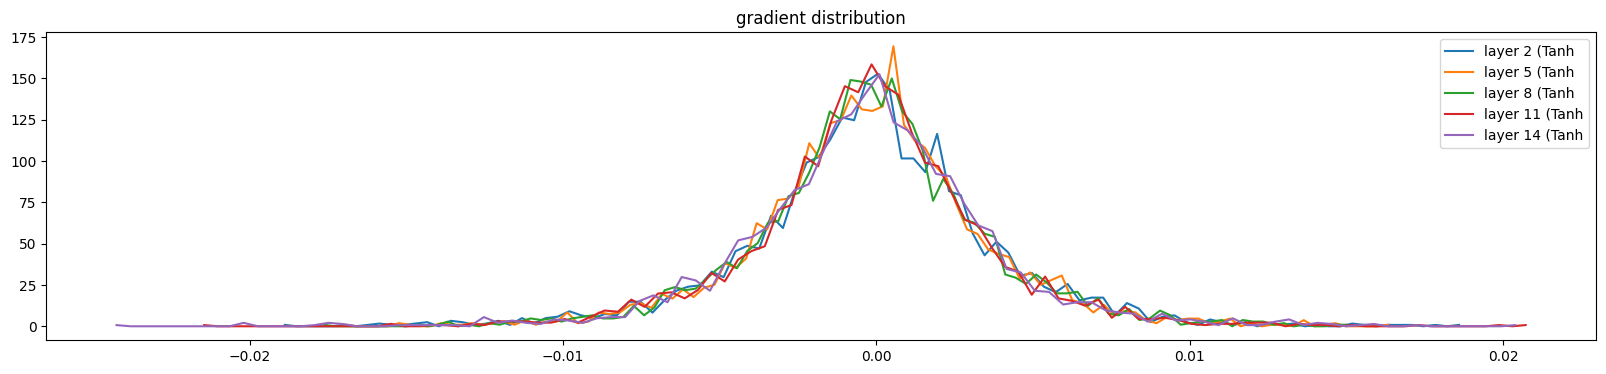

In [15]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

Hikayesi:
- Kahinimiz işçilere(nöronlara) bir kelimeyi öğrenmek için çalışıyor ve model onlara 'Daha iyi Tahmin yapın' diye notlar(gradyanlar) gönderiyor.
- Bu grafik bu notların ne kadar büyük veya ne kadar küçük olduğunu ve nasıl dağıldığını gösteriyor.Her renk kahinin farklı bir katmandaki işçilere gönderdiği notları temsil ediyor.
  - Notlar genelde 0 civarında toplanmış, bu iyi , çünkü çok büyük veya çok küçük notlar işçileri karıştırır.
  - Mean(ortalama) 0 'a çok yakın , yani notlar dengeli
  - Std (standart sapma) çok küçük(örneğin : 2.64 * 10^-3),yani notlar birbirine çok yakın---> buda öğrenmenin düzenli olduğunu gösteriyor.

Kodun Amacı:
Bu kod, sinir ağındaki Tanh katmanlarının çıktılarındaki gradyanların (geri yayılım gradyanlarının) dağılımını görselleştiriyor. Gradyanlar, parametrelerin ne kadar değişeceğini belirler ve öğrenme sürecinin sağlığını gösterir.

- Çıktı Analizi
1. Metin Çıktısı
  - Mean: Gradyanların ortalaması, 0’a çok yakın. Bu, simetriyi ve dengeli öğrenmeyi gösterir.
  - Std: Standart sapma, <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mn>1</mn><msup><mn>0</mn><mrow><mo>−</mo><mn>3</mn></mrow></msup></mrow><annotation encoding="application/x-tex">10^{-3}</annotation></semantics></math> mertebesinde (çok küçük). Bu, gradyanların dar bir aralıkta olduğunu ve patlama/kaybolma (exploding/vanishing gradients) olmadığını gösterir.
  - Derin katmanlarda (örneğin, layer 14) std biraz azalıyor, bu BatchNorm’un gradyanları stabilize ettiğini ima eder.
2. Grafik
  - X ekseni: Gradyan değerleri (örneğin, -0.015 ile 0.015).
  - Y ekseni: Yoğunluk (density).
  - Her renk, bir Tanh katmanının gradyan dağılımını gösterir (layer 2, 5, 8, 11, 14).
  - Dağılım, 0 civarında keskin bir tepeye sahip, bu gradyanların küçük ve dengeli olduğunu gösterir.

Kodun Satır Satır Açıklaması
1. t = layer.out.grad: Tanh katmanının çıktısının gradyanını alır.
2. print(...): Ortalama ve standart sapmayı yazdırır.
3. torch.histogram(t, density=True): Gradyanların histogramını çizer.
4. plt.plot(...): Histogramı çizgi olarak görselleştirir.
5. plt.legend(...) ve plt.title(...): Etiketler ve başlık ekler.
-- Neden Önemli?
- Gradyanların 0’a yakın olması, öğrenme oranının dengeli olduğunu gösterir.
- Küçük standart sapma, gradyanların kontrol altında olduğunu ve ağın kararsızlaşmadığını belirtir.
- BatchNorm, gradyanların katmanlar arasında tutarlı kalmasını sağlıyor.

weight   (27, 10) | mean +0.000000 | std 1.663569e-02 | grad:data ratio 1.465033e-02
weight  (30, 100) | mean +0.000091 | std 8.728294e-03 | grad:data ratio 2.170926e-02
weight (100, 100) | mean -0.000082 | std 5.386731e-03 | grad:data ratio 2.219804e-02
weight (100, 100) | mean +0.000041 | std 5.294584e-03 | grad:data ratio 2.205262e-02
weight (100, 100) | mean +0.000111 | std 5.522641e-03 | grad:data ratio 2.408412e-02
weight (100, 100) | mean -0.000078 | std 5.132798e-03 | grad:data ratio 2.377123e-02
weight  (100, 27) | mean -0.000272 | std 9.076877e-03 | grad:data ratio 2.580672e-02


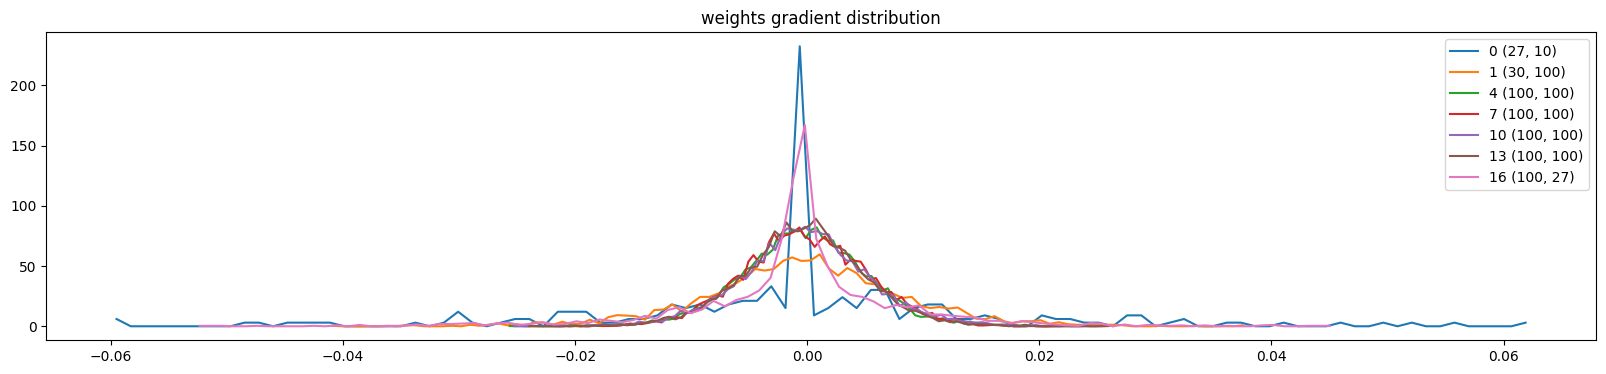

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

-Hikayesi:
Kahinin işçileri(nöronlar) bir kelimeyi öğrenmek için çalışıyor ve her işçinin bir 'ağırlık'(weight) var, yani ne kadar önemli olduklarını gösteren bir sayı.Model bu ağırlıkları "daha iyi yapın" diye güncellemek için notlar(gradyanlar) gönderiyor.Bu grafik bu notların ne kadar büyük veya ne kadar küçük olduğunu ve nasıl dağıldığını gösteriyor.Her renk farklı bir ağırlık grubuna(katmana) ait notları temsil ediyor.

- Notlar genelde 0 civarında toplanmış , bu iyi çünkü çok büyük ve çok küçük notlar işçileri karıştırır.
- Mean(Ortalama) , 0 'a çok yakın , yani notlar dengeli.
- Std(Standart Sapma) küçük Örn: 8.02*10^-3 -- > Yani notlar birbirine yakın
- Grad : data ratio(gradyan : veri oranı), notların ağırlıklara göre ne kadar değiştiğini gösteriyor.buda genelde küçük 8.01*10^3 yani öğrenme düzenli

- Kodun Amacı
  > Bu kod, sinir ağındaki ağırlıkların (weights) gradyanlarının dağılımını görselleştiriyor. Gradyanlar, ağırlıkların güncellenme miktarını belirler ve öğrenme sürecinin stabilitesini gösterir.

Çıktı Analizi:

1. Metin Çıktısı
- Mean: Gradyanların ortalaması, 0’a çok yakın (±0.000246). Bu, dengeli bir güncellemeyi gösterir.
- Std: Standart sapma, <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mn>1</mn><msup><mn>0</mn><mrow><mo>−</mo><mn>3</mn></mrow></msup></mrow><annotation encoding="application/x-tex">10^{-3}</annotation></semantics></math> mertebesinde (çok küçük). Gradyanların dar bir aralıkta olduğunu ve patlama/kaybolma olmadığını belirtir.
- Grad:data ratio: Gradyan standart sapmasının ağırlık standart sapmasına oranı. Küçük değerler (örneğin, <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mn>8.01</mn><mo>×</mo><mn>1</mn><msup><mn>0</mn><mrow><mo>−</mo><mn>3</mn></mrow></msup></mrow><annotation encoding="application/x-tex">8.01 \times 10^{-3}</annotation></semantics></math>), güncellemelerin kontrollü olduğunu gösterir.

2. Grafik
- X ekseni: Gradyan değerleri (örneğin, <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mo>−</mo><mn>0.08</mn></mrow><annotation encoding="application/x-tex">-0.08</annotation></semantics></math> ile <math xmlns="http://www.w3.org/1998/Math/MathML"><semantics><mrow><mn>0.08</mn></mrow><annotation encoding="application/x-tex">0.08</annotation></semantics></math>).
- Y ekseni: Yoğunluk (density).
- Her renk, farklı bir ağırlık matrisinin gradyan dağılımını temsil eder (örneğin, (27, 10) karakter gömülmeleri, (30, 100) ilk katman).
- Dağılım, 0 civarında keskin bir tepeye sahip, bu gradyanların küçük ve dengeli olduğunu gösterir.

- Kodun Satır Satır Açıklaması
  - for i, p in enumerate(parameters): Parametreleri (ağırlıkları) döngüye alır.
  - if p.ndim == 2: Yalnızca 2D matrisler (ağırlıklar) işlenir.
  - t = p.grad: Ağırlıkların gradyanını alır.
  - print(...): Ortalama, standart sapma ve grad:data oranını yazdırır.
  - torch.histogram(t, density=True): Gradyanların histogramını çizer.
  - plt.plot(...): Histogramı çizgi olarak görselleştirir.
  - plt.legend(...) ve plt.title(...): Etiketler ve başlık ekler.
- Neden Önemli?
  - Gradyanların 0’a yakın olması, öğrenme oranının dengeli olduğunu gösterir.
  - Küçük grad:data oranı, ağırlık güncellemelerinin stabil olduğunu ve ağın kararsızlaşmadığını belirtir.
  - BatchNorm, gradyanların katmanlar arasında tutarlı kalmasını destekler.

In [20]:
@torch.no_grad() # Bu dekoratör gradyan takibini devre dışı bırakır

def split_loss(split):
  # Hangi veri setini kullanağımızı belirten bir string(train, val , test)
  x , y = {
      'train' : (Xtr , Ytr),  #Eğitim verisi ve etiketleri
      'val' : (Xdev , Ydev),   #Validasyon(Doğrulama- geliştirme) verisi ve etiketleri
      'test' : (Xte , Yte)     # Test verisi ve etiketleri
  }[split]   #Verilen 'split'adına göre ilgili veri setini aç

  emb = C[x]  # (N , block_size , n_embd)
  # x : Seçilen veri seti --- içindeki harf indexlerini , C matrisindeki gömme vektörlerine dönüştürür
  # N : Örnek sayısı , block_size : Bir girişteki harf sayısı (3) , n_embd : Her harfin vectör boyutu (10)

  x = emb.view(emb.shape[0] , -1) # Concat into ( N , block_size * n_embd)
  #Gömme vektörlerini birleştirerek her bir örnek için tek bir uzun vektör oluşturur.
  # örneğin 3 harflik bir block_size ve 10'luk n_embd varsa 30 boyutlu bir vektör oluşturur

  for layer in layers:
    x = layer(x)  #Veriyi daha önce tanımladığımız ağ katmanlarından sırayla geçir

  loss = F.cross_entropy(x , y) # Modelin tahminleri (x) ile gerçek değerler(y) arasındaki kaybı hesapla
  print(split,loss.item()) # Hangi veri seti için olduğunu ve kayıp değerini ekrana yazdır.

# Katmanları değerlendirme moduna al
for layer in layers:
  layer.training = False


Hikayesi:
1. emb = C[x] : Seçilen veri setindeki(x) karakter indexleri , C gömme matrisi kullanılarak karşılık gelen vektörlere çevrilir.
2. x = emb.view(...) : Bu karakter vektörleri her bir giriş örneği için tel bir uzun vektör haline getirir.
3. for layer in layers : x = layer(x) : Birleştirilmiş vektör , sinir ağının tüm katmanlarından geçirilir.Her katman kendi işlemlerini yapar ve çıktısını bir sonrakine verir.
4. loss = f.cross_enropy(x,y) : Ağın son çıktısı (x - tahmin edilen skorlar) ile gerçek hedef harfler(y) karşılaştırılır ve aralarındaki fark (kayıp) cross_entropy fonksiyonu ile hesaplanır.
5. print(split, loss.item()): Hangi veri setinde ('train', 'val' vb.) çalışıldığını ve hesaplanan kayıp değerini (loss.item() sayıyı bir Python float'ına çevirir) ekrana yazdırır. Bu, kahinimizin o sınav kağıdından kaç puan aldığını gösterir (düşük puan daha iyi).

- for layer in layers:
    - layer.training = False

Hikayesi: Kahinimizi sınava sokmadan önce, ona "Şimdi sınav zamanı, yeni bir şey öğrenmeye çalışma, sadece bildiklerini göster!" diyoruz.
layer.training = False: Ağımızdaki her bir katman için (Linear, BatchNorm1d, Tanh), training özelliğini False olarak ayarlıyoruz.
- Neden Önemli? Bu, özellikle BatchNorm1d gibi bazı katmanlar için çok önemlidir.
-  BatchNorm1d katmanı eğitim sırasında (self.training == True) o anki mini-batch'in ortalamasını ve varyansını kullanırken, değerlendirme sırasında (self.training == False) eğitim boyunca biriktirdiği "koşan ortalama" (running_mean) ve "koşan varyans" (running_var) değerlerini kullanır.
- Değerlendirme yaparken, tüm veri seti üzerinden tutarlı bir normalleştirme yapmak isteriz. Eğer training modu True kalsaydı, BatchNorm1d o anki (belki de küçük) değerlendirme batch'inin istatistiklerini kullanırdı, bu da sonuçları yanıltıcı yapabilirdi. False yaparak, tüm eğitim boyunca öğrenilmiş genel istatistikleri kullanmasını sağlarız.
- Linear ve Tanh katmanları için training özelliğinin doğrudan bir etkisi olmayabilir (çünkü __call__ metotlarında bu bayrağa göre farklı bir davranış tanımlanmamış), ancak bu genel bir pratiktir ve özellikle BatchNorm veya Dropout (bu kodda yok ama yaygındır) gibi katmanlar içeren ağlarda kritik öneme sahiptir.

In [21]:
split_loss('train') # Eğitim seti üzerindeki kaybı  hesapla ve yazdır
split_loss('val') # Doğrulama seti üzerindeki kaybı hesapla ve yazdır

train 2.0017473697662354
val 2.0784716606140137


- Artık katmanlarımız "sınav modunda" (layer.training = False) olduğuna göre, split_loss fonksiyonunu çağırarak kahinimizin performansını ölçebiliriz:
- split_loss('train'): Kahinimizin eğitim verisi üzerinde ne kadar iyi performans gösterdiğini kontrol ederiz. Bu, genellikle en düşük kayıp değeri olur, çünkü model bu veriyi görerek eğitilmiştir. "Ezberleyip ezberlemediğini" bir nebze gösterir.
- split_loss('val'): Kahinimizin daha önce görmediği doğrulama verisi üzerinde ne kadar iyi performans gösterdiğini kontrol ederiz. Bu, modelin genelleme yeteneği hakkında daha iyi bir fikir verir. Eğer eğitim kaybı çok düşük ama doğrulama kaybı çok yüksekse, bu "aşırı öğrenme" (overfitting) belirtisi olabilir; yani model eğitim verisini ezberlemiş ama yeni verilere iyi adapte olamıyor demektir.

Özetle Ne Yaptık?

1. Kahinimize dedik ki: "Hesaplamalar sırasında gradyanları (öğrenme ipuçlarını) takip etme, çünkü şu an sadece notlarını kontrol ediyoruz" (@torch.no_grad()).
2. Kahinimizin içindeki katmanlara (özellikle BatchNorm1d'ye) "Şimdi sınavdasın, eğitim sırasında öğrendiğin genel bilgileri kullan, anlık duruma göre davranma" dedik (layer.training = False).
3. Sonra kahinimizi sırasıyla eğitim verisiyle (split_loss('train')) ve doğrulama verisiyle (split_loss('val')) sınava soktuk ve her bir sınavdan aldığı hata puanını (loss) ekrana yazdırdık.

In [24]:
# Modelden basit örnek

g = torch.Generator().manual_seed(42 + 10) #Rastgele sayı üretecini başlatır ve sabit bir seed(tohum) ayarlar ..+10 diğer ürettiklerinden farklı olması için

for _ in range(20): #20 kez kelime üretmesi için döngü başlattık. Her döngüde yeni bir kelime oluşturacaz

  out = [] #Üretilen harf indexlerini saklamak için boş bir liste oluşturduk
  context = [0] * block_size # Bağlam penceresini sifirlarla başlatır

  while True: #Bir kelimeyi üretmek için döngü başlar kelime özel token 0 gelene kadar devam eder
    # Forward pass the neural network --sinir ağı ileri yayılımı
      emb = C[torch.tensor([context])] # (1, block_size,n_embd)
      # Mevcut bağlamı (context) al , Pytorch tensörüne çevir ve C matrisinden gömme vektörlerini çek
      #[context] -> batch boyutu 1 olan bir tensör oluşturur

      x = emb.view(emb.shape[0] ,-1) #  concatenate the vectors -- > Vektörleri birleştir --- Gömme vektörlerini tek bir uzun vektöre çevir

      for layer in layers:
          x = layer(x)   # Verileri ağ katmanından geçir
      logits = x   ## Ağın son çıktısını (ham skorlar -- olasılık değil)

      probs = F.softmax(logits,1)
      # Logitleri yani ham skorları olasılıklara dönüştür.
      # F.softmax : Skorları , toplamları 1 olacak şekilde olasılık değerlerine çevirir.
      # dim = 1 : Olasılıkların satır bazında (her bir olası sonraki karakter için ) hesaplanmasını sağlar.

      ### DAĞILIMLARDAN ÖRNEKLER SEÇ ###
      ix = torch.multinomial(probs,num_samples= 1, generator=g).item()
      # probs : Hesaplanan olasılıklar
      # num_samples = 1 : Sadece 1 harf seç
      # generator = g : Belirlediğimiz rastgele sayı üretecini seç
      #.item() : Seçilen harfin indexini (tek elemanlı tensörden)  Python sayısına çeviriyor

      # # # BAĞLAM PENCERESİNİ KAYDIR VE ÖRNEKLERİ TAKİP ET  # # #
      context = context[1 :] + [ix]   #En eski harfi at ve yeni seçilen harfi sona ekle
      out.append(ix)   #Seçilen harfin indexini 'out' listesine ekle

      if ix == 0:  # Eğer özel '.' karakterini seçersek , döngüyü kır
         break

    # ÜRETİLEN KELİMEYİ İNSANIN OKUYACAĞI HALE GETİRME #
  print(''.join(itos[i] for i in out))
    # itos : İndexten - harfe çevirme sözlüğü
    # out listesindeki her bir indeksi al , itos ile harfe çevir ve sonra tüm harfleri birleştirerek yazdır.

ellane.
fert.
elyn.
suverity.
lau.
jetlo.
cazleigh.
kaya.
aekya.
azelluki.
paultha.
eilanne.
mar.
ana.
avie.
ansh.
rhetz.
jheliachi.
nate.
jaheem.


- out = []: Her yeni kelime üretimine başlarken, o kelimeyi oluşturacak harflerin (daha doğrusu harf indekslerinin) saklanacağı boş bir liste oluşturuyoruz.
- context = [0] * block_size: Kahinimize bir sonraki harfi tahmin etmesi için bir "başlangıç ipucu" veya "bağlam" vermemiz gerekiyor.
- block_size: Modelimizin bir seferde kaç harflik bir geçmişe baktığını belirler (önceki kodlardan).
- [0] * block_size: Bağlamı, block_size uzunluğunda ve tamamı 0 olan bir listeyle başlatıyoruz. Burada 0 indeksinin özel bir anlama geldiğini varsayıyoruz: genellikle ya bir "boşluk" karakterini, ya bir "kelime başlangıcı" işaretçisini ya da bu örnekteki gibi özel bir "sonlandırma" karakterini (genellikle . ile temsil edilir) ifade eder. Yani kahine, "Haydi, en baştan başla, sana block_size uzunluğunda boş bir sayfa veriyorum" demiş oluyoruz.

Bu kısım, split_loss fonksiyonundaki ileri yayılıma çok benzer:
- emb = C[torch.tensor([context])]: Mevcut context (harf indekslerinden oluşan liste), PyTorch tensörüne dönüştürülür (önüne bir de "batch boyutu" eklenir, sanki tek bir örnekten oluşan bir batch gibi) ve C gömme matrisinden karşılık gelen harf vektörleri alınır.
- x = emb.view(...): Bu harf vektörleri birleştirilerek ağın girişine uygun hale getirilir.
- for layer in layers: x = layer(x): Birleştirilmiş vektör, ağın tüm katmanlarından geçirilir. ÖNEMLİ: Bu aşamada, bir önceki kod parçasında olduğu gibi, tüm katmanların layer.training = False modunda olması gerekir. Bu, özellikle BatchNorm1d katmanlarının doğru (eğitimdeki koşan ortalamalarla) çalışması için kritik öneme sahiptir.
- logits = x: Ağın son katmanından çıkan değerler logits olarak adlandırılır. Bunlar, bir sonraki harfin her bir olası karakter olma olasılığına karşılık gelen ham, normalize edilmemiş skorlardır.